<a href="https://colab.research.google.com/github/Wyndegarde/UFC-Scraper/blob/main/UFC_Scraper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip3 install requests
#!pip3 install beautifulsoup4
import requests
import pprint as pp
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from dateutil.relativedelta import relativedelta

from datetime import datetime, date
import math
import statistics

from sklearn.linear_model import LinearRegression
#import statsmodels.api as sm
import statsmodels.formula.api as smf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def parse_webpage(link):
  get = requests.get(link)
  soup = BeautifulSoup(get.content, 'lxml')
  return(soup)
  
def strip_ufc_text(text):
  text = text.strip().replace('\n','').replace("    ",'')
  return(text)

def get_fighter(df,fighter): 
  df1 = df[df['red_fighter'] == fighter ] 
  df2 = df[df['blue_fighter'] == fighter ]
  df3 = pd.concat([df1,df2],axis = 0)
  return(df3)

# Taken from Lewis' code

#Function for changing height column to inches and then to cm 
def height_to_cm(height):
  if height == '--': 
    return(np.nan)
  else:
    height =height.split("' ")
    feet = float(height[0])
    inch = float(height[1].replace("\"",""))
    feet_inch = (12*feet) + inch
    return(feet_inch*2.54)


#Convert both reach columns into cm
def reach_cm(reach):
    if reach == '--': # bit of a messy change, but currently I replace all of these strings with NaN, then work out the newly mean of the column excluding these values and finally replace the NaN with the mean. 
        return(np.nan)
    else: 
        reach = float(reach.replace('"',''))
        return(reach*2.54) 

# Scraping, cleaning and preparing data for modelling

## Building scraper

### Notes: 

* documentation for datetime: https://docs.python.org/2/library/datetime.html#strftime-and-strptime-behavior


* Tutorial here: https://www.dataquest.io/blog/python-datetime-tutorial/ 

### Links to all events and functions

In [ ]:
all_links = [] # List to store all URLs 
ufc_URL = 'http://ufcstats.com/statistics/events/completed' # Link to UFC stats page with all events 
sequence = list(range(1,22)) # excluding last page of stats due to error, can fix using a try/except block but will return to this later as want to learn properly. 

                             # There are 22 pages, think there may be a better way to do this, but for now will do. 
                             # Idea: read in the page, find the section with page numbers, save 1 and then the final page text, save each as variable and use those for range. 
                             # More work than necessary tho, but idea for future. 

for i in sequence: 
  url = requests.get(ufc_URL, params={'page':i}) # Gets the page, 1 through 22.
  soup = BeautifulSoup(url.content, 'lxml') # Parses the webpage 

  for link in soup.find_all('a',class_="b-link b-link_style_black", href = True): # For each link in each page, go through them
    event = link['href'] # assigns each link to 'event'
    all_links.append(event) # appends this link to main list. 

    # print(f'added {link.text}') # Used to show which events have been added to the list. 

    
  print(f'Page {i} complete') # Just used as indicator to show page has been processed. 

In [ ]:
# # from requests.exceptions import HTTPError # This block here will raise errors if something wrong occurs. see: https://realpython.com/python-requests/

# # # 200's = success, 300's = redirects, 400's = client errors and 500's = server errors. 

# for url in all_links:
#     try:
#         response = requests.get(url)

#         # If the response was successful, no Exception will be raised
#         response.raise_for_status()
#     except HTTPError as http_err:
#         print(f'HTTP error occurred: {http_err}')  
#     except Exception as err:
#         print(f'Other error occurred: {err}') 
#     else:
#         # print('Success!')
#         continue             
# # #         # No errors when going through all the event links. But the code takes a good while to run through all links. 5 minute, 46 second runtime. 549 links. 

### Scraping fight info from all events


In [ ]:
# Notes: Gathered the names through scraping, then added red/blue prefixes. 
#        Find out if there is a better way to do this. 

column_names =['date','location',
               'red_fighter', 'blue_fighter', 'winner', 'weight_class','title_fight',
               'red_knockdowns','blue_knockdowns',
               'red_sig_strike', 'blue_sig_strike',
               'red_sig_strike_percent', 'blue_sig_strike_percent',
               'red_total_strikes', 'blue_total_strikes',
               'red_takedowns', 'blue_takedowns',
               'red_takedown_percent', 'blue_takedown_percent',
               'red_submission_attempts', 'blue_submission_attempts',
               'red_reversals', 'blue_reversals',
               'red_control_time', 'blue_control_time']

event_stats = pd.DataFrame(columns = column_names)

fighter_profile_df = pd.DataFrame(columns =
                                  ['red_Record','red_Height','red_Weight','red_Reach','red_STANCE','red_DOB','red_SLpM',
                                   'red_Str_Acc','red_SApM','red_Str_Def','red_TD_Avg','red_TD_Acc','red_TD_Def','red_Sub_Avg',
                                   'blue_Record','blue_Height','blue_Weight','blue_Reach','blue_STANCE','blue_DOB','blue_SLpM',
                                   'blue_Str_Acc','blue_SApM','blue_Str_Def','blue_TD_Avg','blue_TD_Acc','blue_TD_Def','blue_Sub_Avg'])

# Runtime of this block: for 10 pages - 55 mins(ish), for 21 pages - 1hr 51mins

for event in all_links:           # Goes through each event that was saved. 
  ufc_card = parse_webpage(event) # Parses each event. 


  event_info = ufc_card.find(class_ = 'b-list__box-list').text.replace('\n','').split('      ') # Gets the Date and Location. 
  date = event_info[3]
  location = event_info[-1]

  fight_links = []
  for tag in ufc_card.find_all():
    link_to_fight = tag.get('data-link')
    if link_to_fight != None and 'fight-details' in link_to_fight:
      fight_links.append(link_to_fight)

  for fights in fight_links: # Goes the statistics page of each fight for each event. 
    red_vs_blue = parse_webpage(fights) # Parses each webpage. 
    fighter_links = []
    for link in red_vs_blue.find_all('a',class_ = 'b-link b-link_style_black',limit = 2): # Gets the links to each fighter's profile page and stores them in a list. 
        fighter_links.append(link.get('href'))


    weight = red_vs_blue.find(class_ = 'b-fight-details__fight-title').text
    if 'Title' in weight: 
      title_bout = 'Y'
    else:
      title_bout = 'N'
    content = strip_ufc_text(weight).replace(' Bout','').replace(' Title','')  
    # weights.append(content)
    # for_title.append(title_bout)


    all_info = []
    for link in fighter_links: # We get the links for both fighters in each fight and go through both. 
      profile = parse_webpage(link)
      record = profile.find(class_ = 'b-content__title-record') # First find their record. 
      all_info.append(strip_ufc_text(record.text).split(':'))   # Strip it down and add it to the list

      career_info = profile.find_all(class_="b-list__box-list-item b-list__box-list-item_type_block") # Next we go through all of the summary stats for each fighter. 
      for each in career_info:
        output = strip_ufc_text(each.text).split(':') # Strip the text containing the info and then split it by colons, to have a list where each entry is a 2 element list containing the name of the stat and the stat itself. 
        all_info.append(output) # Add the info for each fighter to the list. This adds all red fighter stats, then loops through again to add blue fighter stats to end of that. 


    # Once both fighter statistics from a single fight have been extracted and stored in a list, we need to process that list and add it to the dataframe as one row. 
    all_info.remove(all_info[10]) # This is an empty entry due to website formatting. 
    all_info.remove(all_info[-5]) # see above 

    information = [i[1] for i in all_info] # This here creates a list containing only the actual statistics (effectively discarding the names)
    information_series = pd.Series(information,index = fighter_profile_df.columns) # converts this list to a series so it can be added to the dataframe. 
    fighter_profile_df = fighter_profile_df.append(information_series, ignore_index=True) # Finally add the fighter stats to the dataframe. 
      
    outcome = red_vs_blue.find(class_ = 'b-fight-details__person').find(class_ = 'b-fight-details__person-status b-fight-details__person-status_style_gray')
    if outcome == None:
      win = 'W'
    else: 
      win= strip_ufc_text(outcome.text)
    
    table = []
    for link in red_vs_blue.find_all(class_ = 'b-fight-details__table-text', limit = 20): # Goes through the table containing the key information from each fight and stores the stats in a list. 
        entry = strip_ufc_text(link.get_text())
        table.append(entry)

    # This code here adds the date, location and winner information to the list and then adds that row to the master dataframe. 
    table.insert(0,date)
    table.insert(1,location)
    table.insert(4,win)
    table.insert(5,content)
    table.insert(6,title_bout)
    stats = pd.Series(table, index = column_names)
    event_stats = event_stats.append(stats,ignore_index=True)

UFC_DataFrame = pd.concat([event_stats,fighter_profile_df],axis = 1)
UFC_DataFrame.to_csv('ufcbiggerDraftTwo.csv',index = False)

## Cleaning the scraped Data

In [ ]:
UFC_DataFrame = pd.read_csv('drive/MyDrive/ufcbiggerDraftTwo.csv') # There are two older drafts if need to return to checkpoint. 

In [ ]:
UFC_DataFrame.info()

In [ ]:
# Find out how to do this in Regex. 
words = ['\d+',' Tournament','Interim ','UFC ','Australia ','UK ','vs. ','Brazil ', 'China ','TUF Nations Canada ','America ', 'Latin ','Ultimate Fighter  ','Ultimate Fighter ']
for word in words:
  UFC_DataFrame['weight_class'] = UFC_DataFrame['weight_class'].str.replace(word,'')

In [ ]:
for column in UFC_DataFrame.columns:
  if len(UFC_DataFrame[column][UFC_DataFrame[column] == '--']) > 0:
    print(column, len(UFC_DataFrame[column][UFC_DataFrame[column] == '--']))
# Will drop the rows with missing days of birth for now. Return to this and investigate whether they can be filled in from the dataframe or if I would have to do manually. 

red_Height 1
red_Reach 197
red_DOB 5
blue_Height 2
blue_Reach 633
blue_DOB 43


In [ ]:
drop_columns = []
for column in UFC_DataFrame.columns:
  if len(UFC_DataFrame[column][UFC_DataFrame[column] == '---']) > 0:
    drop_columns.append(column)
    print(column, len(UFC_DataFrame[column][UFC_DataFrame[column] == '---']))

# We will just drop these columns, they are recreated in cleaning with slightly more precise values. 

red_sig_strike_percent 21
blue_sig_strike_percent 25
red_takedown_percent 1818
blue_takedown_percent 2111


In [ ]:
height_reach = []
for column in UFC_DataFrame.columns:
  if 'Reach' in column or 'Height' in column:
    height_reach.append(column)

In [ ]:
UFC = UFC_DataFrame.copy()

grouped_df = UFC.copy()
grouped_df = grouped_df.dropna(subset = height_reach)

for column in height_reach:
  if 'Height' in column:
    grouped_df[column] = grouped_df[column].apply(lambda x:height_to_cm(x))
  else:
    grouped_df[column] = grouped_df[column].apply(lambda x:reach_cm(x))

grouping_by_weight_classes = grouped_df.groupby('weight_class').mean()
reach_height_df = grouping_by_weight_classes[height_reach]

UFC = UFC[UFC['blue_DOB'] != '--']
UFC = UFC[UFC['red_DOB'] != '--']
UFC = UFC.drop(drop_columns,axis = 1)

UFC['date'] = UFC['date'].apply(lambda x: datetime.strptime(x,'%B %d, %Y')) 

for column in UFC.columns: 
  if 'DOB' in column:
    UFC[column] = UFC[column].apply(lambda x: datetime.strptime(x,'%b %d, %Y')) 

UFC = UFC.replace('---','0')
UFC['blue_STANCE'] = UFC['blue_STANCE'].replace(np.nan,'Orthodox') # Choosing the replace with Orthodox because it is the most common stance. 
UFC['red_STANCE'] = UFC['blue_STANCE'].replace(np.nan,'Orthodox') # see above
#UFC = UFC.sort_values(by = 'date', ascending = False) # This is not totally necessary, but handy for if anything gets jumbled up later on when appending. 

UFC_subset = UFC.copy()
UFC_subset = UFC_subset[['date', 'location', 'red_fighter', 'blue_fighter', 'winner','weight_class','title_fight','red_sig_strike','blue_sig_strike', 
                                 'red_total_strikes', 'blue_total_strikes', 'red_takedowns','blue_takedowns',
                                 'red_submission_attempts', 'blue_submission_attempts', 'red_Record',
                                 'red_Height', 'red_Weight', 'red_Reach', 'red_STANCE', 'red_DOB', 'blue_Record', 'blue_Height',
                                 'blue_Weight', 'blue_Reach', 'blue_STANCE', 'blue_DOB']]


# This block here pulls all the percentage columns, then removes the % from each and converts them to decimal. 
percent_names = []
of_columns = []
height_columns = []
reach_columns = []

for name in UFC_subset.columns: 

  if 'percent' in name:
    percent_names.append(name)

  elif UFC_subset[name].dtype == object and sum(UFC_subset[name].apply(lambda x: 'of' in str(x))) > 0 and name != 'red_fighter' and name != 'blue_fighter' : # This is definitely not the best way to do this, find better way.
    of_columns.append(name) # This block gets all the columns with ' x of y' in them and stores them in a list for processing.

  elif 'Height' in name: # This block converts the height and reach columns from inches to cm. 
    height_columns.append(name)
    UFC_subset[name] = UFC_subset[name].apply(lambda x:height_to_cm(x))

  elif 'Reach' in name: 
    reach_columns.append(name)
    UFC_subset[name] = UFC_subset[name].apply(lambda x:reach_cm(x))


for column in percent_names: 
  UFC_subset[column] = UFC_subset[column].str.strip('%').astype('int')/100


for column in of_columns: # This block converts all the columns from strings containing "x of y" to two columns corresponding to attempted and landed. 
  column_as_list = UFC_subset[column].tolist()
  splitting_column = []

  for each in column_as_list: 
    splitting_column.append(each.split(' of '))
  
  attempted = [float(i[1]) for i in splitting_column] 
  landed = [float(i[0]) for i in splitting_column] 

  attempted_suffix = column + '_attempted'
  landed_suffix = column + '_landed'
  percent_suffix = column + '_percent'
 
  UFC_subset[attempted_suffix] = attempted 
  UFC_subset[landed_suffix] = landed
  UFC_subset[percent_suffix] =  UFC_subset[landed_suffix] / UFC_subset[attempted_suffix] 
  UFC_subset[percent_suffix] = UFC_subset[percent_suffix].fillna(0)

  UFC_subset = UFC_subset.drop(columns = column)

missing_value_df = UFC_subset.copy()
missing_value_df = missing_value_df[missing_value_df.isna().any(axis = 1)] # Could make more generic and have the loop below run through all of UFC subset, but wanted to cut run time down. 
missing_value_df = missing_value_df[height_reach]

for column in height_reach:
  for i in missing_value_df.index:
    if np.isnan(missing_value_df.loc[i,column]) == True:
      UFC_subset.loc[i,column] = reach_height_df.loc[UFC_subset.loc[i,'weight_class'],column]

UFC_subset['Height_diff'] = UFC_subset[height_columns[0]] - UFC_subset[height_columns[1]] # Red height minus Blue height. So positve value suggests red taller, negative implies red shorter.
UFC_subset['Reach_diff'] = UFC_subset[reach_columns[0]] - UFC_subset[reach_columns[1]]  # Same as for height. 

UFC_subset['red_age'] = UFC_subset['date'].sub(UFC_subset['red_DOB']).dt.days.div(365.25).round(0).astype(int)
UFC_subset['blue_age'] = UFC_subset['date'].sub(UFC_subset['blue_DOB']).dt.days.div(365.25).round(0).astype(int)

# I need: strike defence and takedown defence for red and blue fighters
 
UFC_subset['red_sig_strike_defence_percent'] = 1-  UFC_subset['blue_sig_strike_percent'] 
UFC_subset['blue_sig_strike_defence_percent'] = 1-  UFC_subset['red_sig_strike_percent'] 

UFC_subset['red_takedowns_defence_percent'] = 1-  UFC_subset['blue_takedowns_percent'] 
UFC_subset['blue_takedowns_defence_percent'] = 1-  UFC_subset['red_takedowns_percent'] 

number_of_fights_per_fighter = UFC_subset['red_fighter'].append(UFC_subset['blue_fighter']).value_counts()

In [ ]:
UFC_subset.isna().sum()

date                               0
location                           0
red_fighter                        0
blue_fighter                       0
winner                             0
weight_class                       0
title_fight                        0
red_submission_attempts            0
blue_submission_attempts           0
red_Record                         0
red_Height                         0
red_Weight                         0
red_Reach                          0
red_STANCE                         0
red_DOB                            0
blue_Record                        0
blue_Height                        0
blue_Weight                        0
blue_Reach                         0
blue_STANCE                        0
blue_DOB                           0
red_sig_strike_attempted           0
red_sig_strike_landed              0
red_sig_strike_percent             0
blue_sig_strike_attempted          0
blue_sig_strike_landed             0
blue_sig_strike_percent            0
r

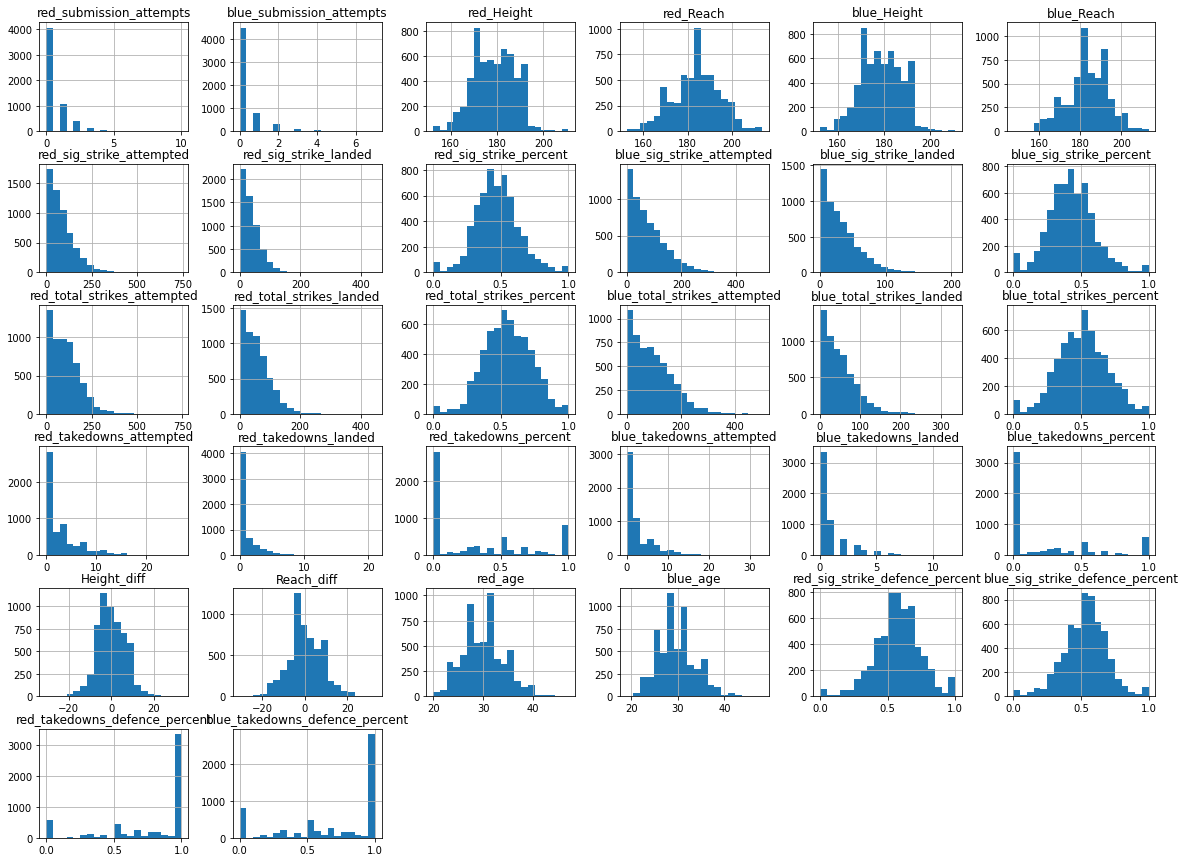

In [ ]:
%matplotlib inline 
UFC_subset.hist(bins=20, figsize=(20,15))
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


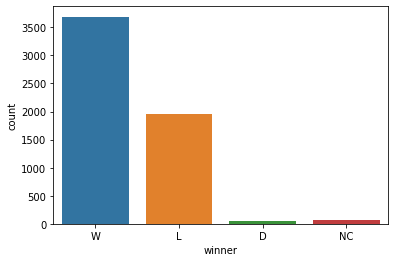

In [ ]:
sns.countplot(UFC_subset['winner'])

In [ ]:
number_of_fights_per_fighter

Donald Cerrone     37
Jim Miller         37
Andrei Arlovski    33
Jeremy Stephens    33
Diego Sanchez      32
                   ..
Kanako Murata       1
Javier Vazquez      1
Rocky Lee           1
Roger Zapata        1
Daniel Spohn        1
Length: 1936, dtype: int64

In [ ]:
number_of_fights_per_fighter[number_of_fights_per_fighter == 1] 

John Marsh          1
Tim McKenzie        1
Kimo Leopoldo       1
Anthony Torres      1
Antonio Banuelos    1
                   ..
Kanako Murata       1
Javier Vazquez      1
Rocky Lee           1
Roger Zapata        1
Daniel Spohn        1
Length: 267, dtype: int64

In [ ]:
number_of_fights_per_fighter[number_of_fights_per_fighter >= 3]

Donald Cerrone       37
Jim Miller           37
Andrei Arlovski      33
Jeremy Stephens      33
Diego Sanchez        32
                     ..
Clifford Starks       3
Dale Hartt            3
Wellington Turman     3
Jamie Mullarkey       3
Phil Hawes            3
Length: 1311, dtype: int64

## Creating averages for key stats

### Building Regression model 

* We don't have the average for each fighter going into their first fight, so need to fill this in. This is done using linear regression. 

* Where the independent variable is the fighter's average going into fight t. and the dependent variable is the average going into fight t-1. 

* For this reason we can only include fighters with 3 + fights in the dataset, but we can then have one dataset for the model as long as each x and y match up. 

In [ ]:
UFC_key_columns = UFC_subset.copy()
UFC_key_columns = UFC_key_columns[['date','red_fighter','blue_fighter','winner',
                                   'red_sig_strike_percent', 'blue_sig_strike_percent',
                                   'red_submission_attempts', 'blue_submission_attempts', 
                                   'red_STANCE', 'blue_STANCE', 'red_total_strikes_percent',
                                   'blue_total_strikes_percent', 'red_takedowns_percent',
                                   'blue_takedowns_percent', 'Height_diff', 'Reach_diff', 
                                   'red_age','blue_age','red_sig_strike_defence_percent',
                                   'blue_sig_strike_defence_percent', 'red_takedowns_defence_percent',
                                   'blue_takedowns_defence_percent']]

fighters = np.unique(np.concatenate([UFC_subset['red_fighter'], UFC_subset['blue_fighter'] ], axis = None)) 

percent_stats = []
for column in UFC_subset.columns:
  if 'percent' in column and not 'total' in column:
    column_name = column.replace('red_','').replace('blue_','')
    if column_name not in percent_stats:
      percent_stats.append(column_name)
      print(column_name)

sig_strike_percent
takedowns_percent
sig_strike_defence_percent
takedowns_defence_percent


In [ ]:
# Runtime of block: 1 minute, 30 seconds  - Suggests I may need to improve the loops/algorithm
regression_df = pd.DataFrame()

# Aim for this block of code is to go through each fighter, get the averages they had going into fight t and fight t-1 
# use these to build our X & Y's for the linear regression. Then do this for each relevant stat. 
# Lets us build a linear regression with 3000+ rows of data but have them relevant to each fighter. 

for column in percent_stats:       
  each_stat_df = pd.DataFrame(columns = [column, 'Y_' + column, 'X_' + column]) # Creates a dataframe for each stat. 

  for fighter in fighters: 
    fighter_df = get_fighter(UFC_key_columns,fighter).sort_values(by = 'date', ascending = True) # Gets each fighter and orders their fights, earliest to most recent.

    if len(fighter_df) >= 3: # The dataframe will only work if fighter has 3 or more fights. 
      ordered_stats = []

      for i in fighter_df.index:                      # stores the stat from every fight in a list, accounting for the fact they may be in a different corner (red/blue) each fight
        if fighter in fighter_df.loc[i,'red_fighter']:
          ordered_stats.append(fighter_df.loc[i,'red_' + column])
        if fighter in fighter_df.loc[i,'blue_fighter']:
          ordered_stats.append(fighter_df.loc[i,'blue_' + column])

      lin_reg_df =  pd.DataFrame(ordered_stats, columns=[column])                # Goes through and builds the X and Y data for the linear regression model. 
      lin_reg_df['X_' + column] = lin_reg_df[column].expanding(2).mean().shift(1)
      lin_reg_df.loc[1,'X_' + column] = lin_reg_df.loc[0,column]
      lin_reg_df['Y_' + column] = lin_reg_df['X_' + column].shift(1)
      lin_reg_df = lin_reg_df.dropna()

      each_stat_df = pd.concat([each_stat_df,lin_reg_df], axis = 0) # Adds the rows of each fighter to the dataframe for that stat. 

  regression_df = pd.concat([regression_df,each_stat_df], axis = 1) # Adds the columns for each stat to the master DF. 

regression_df = regression_df.reset_index(drop = True) # Just resets the index. 

XYs_only = regression_df.drop(percent_stats, axis = 1)

In [ ]:
sig_strike_model = smf.ols('Y_sig_strike_percent	~ X_sig_strike_percent', data = XYs_only).fit()
takedowns_model = smf.ols('Y_takedowns_percent	~ X_takedowns_percent', data = XYs_only).fit()


sig_strike_defence_model = smf.ols('Y_sig_strike_defence_percent	~ X_sig_strike_defence_percent', data = XYs_only).fit()
takedowns_defence_model = smf.ols('Y_takedowns_defence_percent	~ X_takedowns_defence_percent', data = XYs_only).fit()

### Assumption Checking for Regression

In [ ]:
print(sig_strike_model.summary())

                             OLS Regression Results                             
Dep. Variable:     Y_sig_strike_percent   R-squared:                       0.762
Model:                              OLS   Adj. R-squared:                  0.762
Method:                   Least Squares   F-statistic:                 2.523e+04
Date:                  Sun, 16 May 2021   Prob (F-statistic):               0.00
Time:                          11:39:46   Log-Likelihood:                 11617.
No. Observations:                  7885   AIC:                        -2.323e+04
Df Residuals:                      7883   BIC:                        -2.322e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept   

In [ ]:
print(sig_strike_defence_model.summary())

                                 OLS Regression Results                                 
Dep. Variable:     Y_sig_strike_defence_percent   R-squared:                       0.723
Model:                                      OLS   Adj. R-squared:                  0.723
Method:                           Least Squares   F-statistic:                 2.060e+04
Date:                          Sun, 16 May 2021   Prob (F-statistic):               0.00
Time:                                  11:39:48   Log-Likelihood:                 11252.
No. Observations:                          7885   AIC:                        -2.250e+04
Df Residuals:                              7883   BIC:                        -2.249e+04
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------

In [ ]:
print(takedowns_model.summary())

                             OLS Regression Results                            
Dep. Variable:     Y_takedowns_percent   R-squared:                       0.716
Model:                             OLS   Adj. R-squared:                  0.715
Method:                  Least Squares   F-statistic:                 1.983e+04
Date:                 Sun, 16 May 2021   Prob (F-statistic):               0.00
Time:                         11:39:50   Log-Likelihood:                 5022.0
No. Observations:                 7885   AIC:                        -1.004e+04
Df Residuals:                     7883   BIC:                        -1.003e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               

In [ ]:
print(takedowns_defence_model.summary())

                                 OLS Regression Results                                
Dep. Variable:     Y_takedowns_defence_percent   R-squared:                       0.705
Model:                                     OLS   Adj. R-squared:                  0.705
Method:                          Least Squares   F-statistic:                 1.887e+04
Date:                         Sun, 16 May 2021   Prob (F-statistic):               0.00
Time:                                 11:39:52   Log-Likelihood:                 5474.9
No. Observations:                         7885   AIC:                        -1.095e+04
Df Residuals:                             7883   BIC:                        -1.093e+04
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------

In [ ]:
sig_strike_pred_val = sig_strike_model.fittedvalues.copy()
sig_strike_true_val = XYs_only['Y_sig_strike_percent'].values.copy()
sig_strike_residual = sig_strike_true_val - sig_strike_pred_val

takedowns_pred_val = takedowns_model.fittedvalues.copy()
takedowns_true_val = XYs_only['Y_takedowns_percent'].values.copy()
takedowns_residual = takedowns_true_val - takedowns_pred_val

sig_strike_defence_pred_val = sig_strike_defence_model.fittedvalues.copy()
sig_strike_defence_true_val = XYs_only['Y_sig_strike_defence_percent'].values.copy()
sig_strike_defence_residual = sig_strike_defence_true_val - sig_strike_defence_pred_val

takedowns_defence_pred_val = takedowns_defence_model.fittedvalues.copy()
takedowns_defence_true_val = XYs_only['Y_takedowns_defence_percent'].values.copy()
takedowns_defence_residual = takedowns_defence_true_val - takedowns_defence_pred_val

Text(0.5, 0, 'Fitted Values')

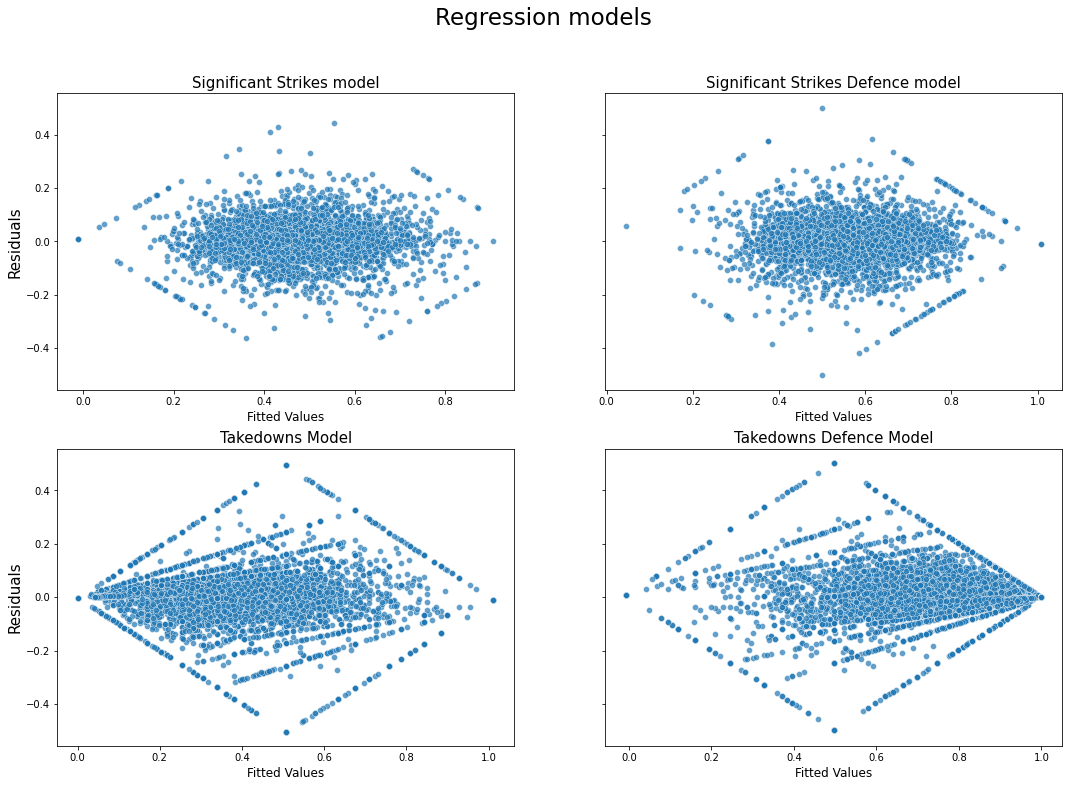

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(18, 12), sharey=True)
fig.suptitle('Regression models',fontsize = 23)

sns.scatterplot(ax=axes[0,0], x=sig_strike_pred_val, y=sig_strike_residual, alpha = 0.7)
axes[0,0].set_title('Significant Strikes model',fontsize = 15)
axes[0,0].set_ylabel('Residuals',fontsize = 15)
axes[0,0].set_xlabel('Fitted Values',fontsize = 12)

sns.scatterplot(ax=axes[0,1], x=sig_strike_defence_pred_val, y=sig_strike_defence_residual, alpha = 0.7)
axes[0,1].set_title('Significant Strikes Defence model',fontsize = 15)
axes[0,1].set_xlabel('Fitted Values',fontsize = 12)

sns.scatterplot(ax=axes[1,0], x=takedowns_pred_val, y=takedowns_residual, alpha = 0.7)
axes[1,0].set_title('Takedowns Model',fontsize = 15)
axes[1,0].set_ylabel('Residuals',fontsize = 15)
axes[1,0].set_xlabel('Fitted Values',fontsize = 12)

sns.scatterplot(ax=axes[1,1], x=takedowns_defence_pred_val, y=takedowns_defence_residual, alpha = 0.7)
axes[1,1].set_title('Takedowns Defence Model',fontsize = 15)
axes[1,1].set_xlabel('Fitted Values',fontsize = 12)

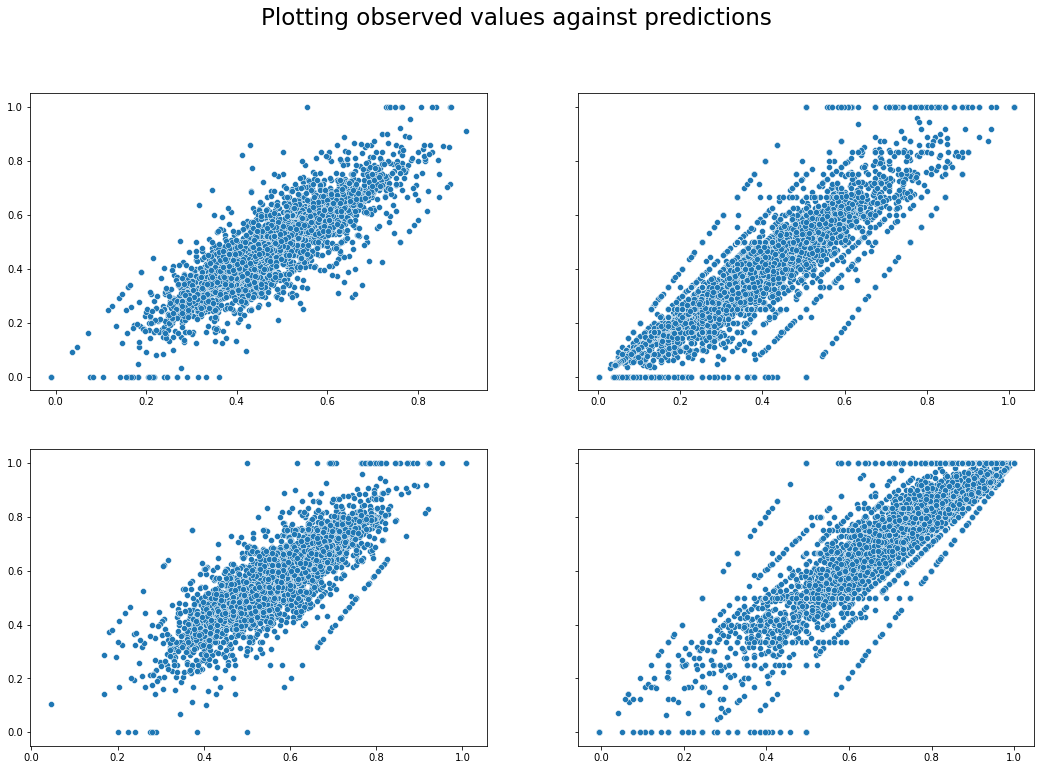

In [ ]:
fig, axes = plt.subplots(2,2,figsize=(18,12),sharey = True)
fig.suptitle('Plotting observed values against predictions',fontsize = 23)

sns.scatterplot(x = sig_strike_pred_val,y = sig_strike_true_val, ax = axes[0,0])
sns.scatterplot(x = takedowns_pred_val,y = takedowns_true_val, ax = axes[0,1])

sns.scatterplot(x = sig_strike_defence_pred_val,y = sig_strike_defence_true_val, ax = axes[1,0])
sns.scatterplot(x = takedowns_defence_pred_val,y = takedowns_defence_true_val, ax = axes[1,1])

Text(0.5, 0, 'Takedown defence')

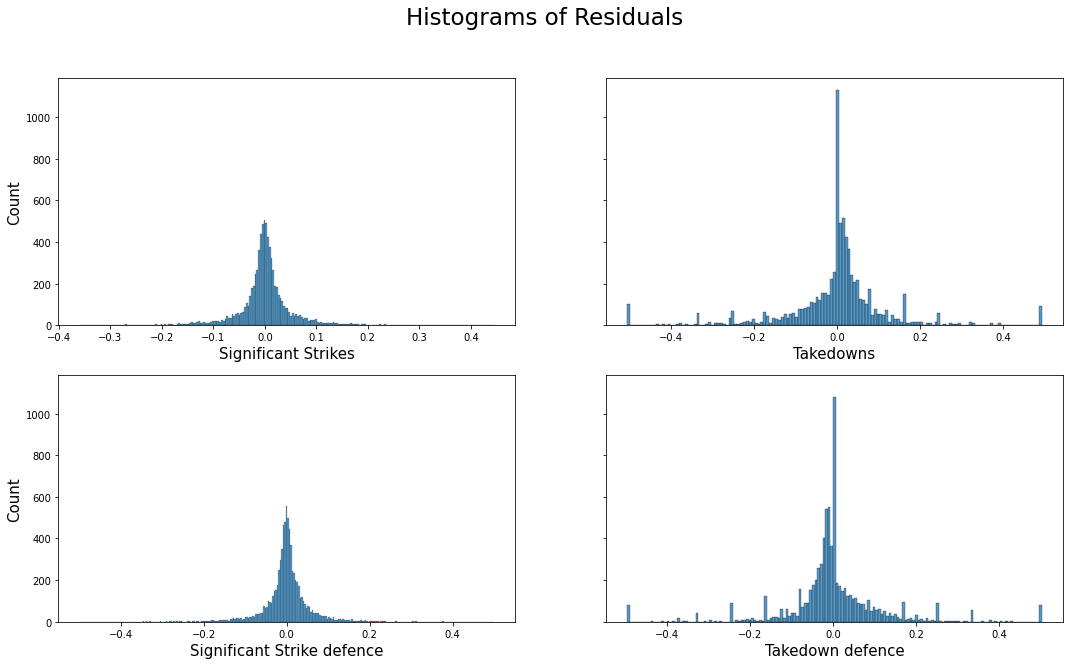

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(18,10), sharey=True)
fig.suptitle('Histograms of Residuals',fontsize = 23)

sns.histplot(sig_strike_residual,ax=axes[0,0])
axes[0,0].set_ylabel('Count',fontsize = 15)
axes[0,0].set_xlabel('Significant Strikes',fontsize = 15)

sns.histplot(takedowns_residual,ax=axes[0,1])
axes[0,1].set_xlabel('Takedowns',fontsize = 15)

sns.histplot(sig_strike_defence_residual,ax=axes[1,0])
axes[1,0].set_ylabel('Count',fontsize = 15)
axes[1,0].set_xlabel('Significant Strike defence',fontsize = 15)

sns.histplot(takedowns_defence_residual,ax=axes[1,1])
axes[1,1].set_xlabel('Takedown defence',fontsize = 15)

Text(0.5, 0, 'Takedown defence')

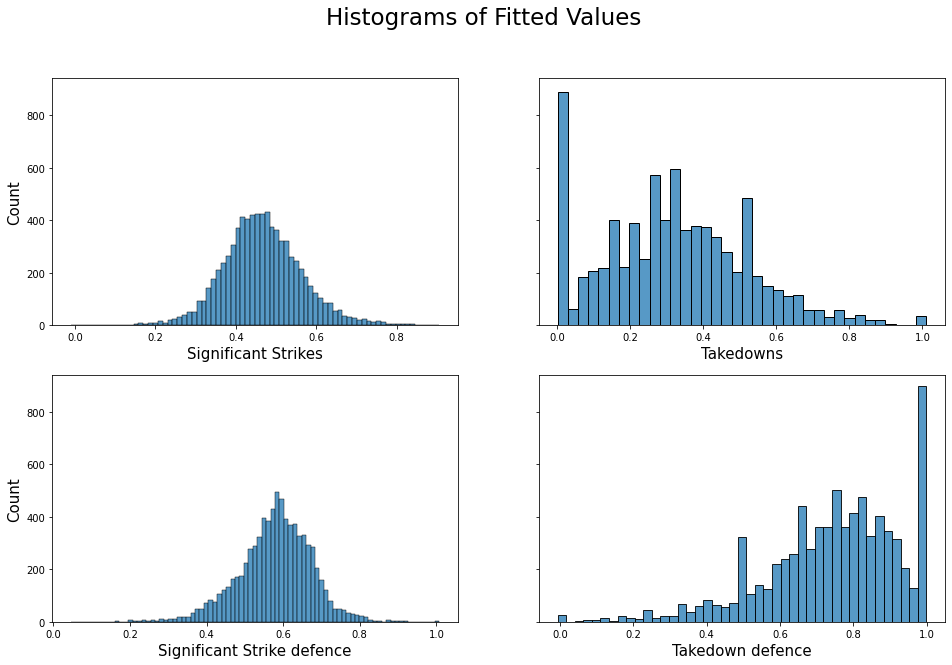

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(16, 10), sharey=True)
fig.suptitle('Histograms of Fitted Values',fontsize = 23)

sns.histplot(sig_strike_pred_val,ax=axes[0,0])
axes[0,0].set_ylabel('Count',fontsize = 15)
axes[0,0].set_xlabel('Significant Strikes',fontsize = 15)

sns.histplot(takedowns_pred_val,ax=axes[0,1])
axes[0,1].set_xlabel('Takedowns',fontsize = 15)

sns.histplot(sig_strike_defence_pred_val,ax=axes[1,0])
axes[1,0].set_ylabel('Count',fontsize = 15)
axes[1,0].set_xlabel('Significant Strike defence',fontsize = 15)

sns.histplot(takedowns_defence_pred_val,ax=axes[1,1])
axes[1,1].set_xlabel('Takedown defence',fontsize = 15)

In [ ]:
print('Takedowns:                  ',min(takedowns_pred_val), max(takedowns_pred_val))
print()
print('Significant Strikes:       ',min(sig_strike_pred_val),max(sig_strike_pred_val))
print()
print('Takedown Defence:          ',min(takedowns_defence_pred_val), max(takedowns_defence_pred_val))
print()
print('Significant Strike Defence: ',min(sig_strike_defence_pred_val),max(sig_strike_defence_pred_val))

Takedowns:                   0.0016577541714583536 1.0109916498227138

Significant Strikes:        -0.0107858956072347 0.9062674907211045

Takedown Defence:           -0.006636632962535747 0.9992294614438374

Significant Strike Defence:  0.04493242586324483 1.0080819772663523


### Filling missing values using linear regression model

In [ ]:
percent_stats

['sig_strike_percent',
 'takedowns_percent',
 'sig_strike_defence_percent',
 'takedowns_defence_percent']

In [ ]:
red_blue_percent_stats = []
for column in UFC_subset.columns:
  if 'percent' in column and 'total' not in column:
    red_blue_percent_stats.append(column)
    print(column)

red_sig_strike_percent
blue_sig_strike_percent
red_takedowns_percent
blue_takedowns_percent
red_sig_strike_defence_percent
blue_sig_strike_defence_percent
red_takedowns_defence_percent
blue_takedowns_defence_percent


In [ ]:
new_columns = []
for name in red_blue_percent_stats:
  string = name.replace('percent','average')
  new_columns.append(string)
  UFC_subset[string] = np.nan
  print(string)

red_sig_strike_average
blue_sig_strike_average
red_takedowns_average
blue_takedowns_average
red_sig_strike_defence_average
blue_sig_strike_defence_average
red_takedowns_defence_average
blue_takedowns_defence_average


In [ ]:
# 46 second runtime. 

for fighter in fighters:
  fighter_df = get_fighter(UFC_subset,fighter).sort_values(by = 'date', ascending = True) # Gets each fighter and orders their fights, earliest to most recent.

  if len(fighter_df) > 1: 
    sig_strikes = []
    takedowns = []
    sig_strike_defence = []
    takedown_defence = []

    for i in fighter_df.index:

      if fighter in fighter_df.loc[i,'red_fighter']:
        sig_strikes.append(fighter_df.loc[i,'red_sig_strike_percent'])
        takedowns.append(fighter_df.loc[i,'red_takedowns_percent'])
        sig_strike_defence.append(fighter_df.loc[i,'red_sig_strike_defence_percent'])
        takedown_defence.append(fighter_df.loc[i,'red_takedowns_defence_percent'])

      if fighter in fighter_df.loc[i,'blue_fighter']:
        sig_strikes.append(fighter_df.loc[i,'blue_sig_strike_percent'])
        takedowns.append(fighter_df.loc[i,'blue_takedowns_percent'])
        sig_strike_defence.append(fighter_df.loc[i,'blue_sig_strike_defence_percent'])
        takedown_defence.append(fighter_df.loc[i,'blue_takedowns_defence_percent'])

    dic = {'sig_strike':sig_strikes,'takedowns':takedowns,'sig_strike_defence':sig_strike_defence,'takedowns_defence':takedown_defence}
    df = pd.DataFrame(dic,index = fighter_df.index)
    
    for column in df.columns:
      column_name = column + '_average'
      df[column_name] =df[column].expanding(2).mean().shift(1)
      df.loc[df.index[1],column_name] = df.loc[df.index[0],column]
    
    predict_sig_strikes = sig_strike_model.predict(exog = dict(X_sig_strike_percent=df.loc[df.index[1],'sig_strike_average']))
    predict_takedowns = takedowns_model.predict(exog = dict(X_takedowns_percent=df.loc[df.index[1],'takedowns_average']))

    predict_sig_strike_defence = sig_strike_defence_model.predict(exog = dict(X_sig_strike_defence_percent=df.loc[df.index[1],'sig_strike_defence_average']))
    predict_takedown_defence = takedowns_defence_model.predict(exog = dict(X_takedowns_defence_percent=df.loc[df.index[1],'takedowns_defence_average']))

    df.loc[df.index[0],'sig_strike_average'] = predict_sig_strikes[0]
    df.loc[df.index[0],'takedowns_average'] = predict_takedowns[0]
    df.loc[df.index[0],'sig_strike_defence_average'] = predict_sig_strike_defence[0]
    df.loc[df.index[0],'takedowns_defence_average'] = predict_takedown_defence[0]

    df = df.drop(columns = ['sig_strike', 'takedowns', 'sig_strike_defence', 'takedowns_defence'])

    for column in df.columns: 
      for i in df.index:
        if fighter in UFC_subset.loc[i,'red_fighter']:
          UFC_subset.loc[i,'red_' + column] = df.loc[i,column]
        elif fighter in UFC_subset.loc[i,'blue_fighter']:
          UFC_subset.loc[i,'blue_' + column] = df.loc[i,column]


In [ ]:
Holland = get_fighter(UFC_subset,'Kevin Holland').sort_values(by = 'date',ascending = False)

In [ ]:
print('Date', "                    ",'Fighter',"     ", "Sig Strike average")
print('-----------------------------------')
for i in Holland.index:
  if 'Kevin Holland' in Holland.loc[i,'red_fighter']:
    print(Holland.loc[i,'date'],"  ",Holland.loc[i,'red_fighter'],"  ",Holland.loc[i,'red_sig_strike_average'])
  if 'Kevin Holland' in Holland.loc[i,'blue_fighter']:
    print(Holland.loc[i,'date'],"  ",Holland.loc[i,'blue_fighter'],"  ",Holland.loc[i,'blue_sig_strike_average'])

Date                      Fighter       Sig Strike average
-----------------------------------
2021-04-10 00:00:00    Kevin Holland    0.645584648104203
2021-03-20 00:00:00    Kevin Holland    0.6614944642659746
2020-12-12 00:00:00    Kevin Holland    0.6424012565918237
2020-10-31 00:00:00    Kevin Holland    0.6081180803324683
2020-09-19 00:00:00    Kevin Holland    0.6130430331152904
2020-08-08 00:00:00    Kevin Holland    0.6169581655001771
2020-05-16 00:00:00    Kevin Holland    0.584794243044657
2019-10-18 00:00:00    Kevin Holland    0.586255961700558
2019-06-22 00:00:00    Kevin Holland    0.6164324503585789
2019-03-30 00:00:00    Kevin Holland    0.6106951871657753
2018-11-24 00:00:00    Kevin Holland    0.5636363636363636
2018-08-04 00:00:00    Kevin Holland    0.5686516580473592


In [ ]:
UFC_subset.isna().sum()

date                                 0
location                             0
red_fighter                          0
blue_fighter                         0
winner                               0
weight_class                         0
title_fight                          0
red_submission_attempts              0
blue_submission_attempts             0
red_Record                           0
red_Height                           0
red_Weight                           0
red_Reach                            0
red_STANCE                           0
red_DOB                              0
blue_Record                          0
blue_Height                          0
blue_Weight                          0
blue_Reach                           0
blue_STANCE                          0
blue_DOB                             0
red_sig_strike_attempted             0
red_sig_strike_landed                0
red_sig_strike_percent               0
blue_sig_strike_attempted            0
blue_sig_strike_landed   

In [ ]:
len(UFC_subset)

5745

In [ ]:
UFC_drop_nas = UFC_subset.dropna()

In [ ]:
len(UFC_drop_nas)

5484

In [ ]:
UFC_drop_nas.to_csv('drive/MyDrive/UFC_Filled_missing_values_no_row_drop.csv',index = False)

## Preparing next event data

### Scraping the data

In [ ]:
cleaned_ufc = pd.read_csv('drive/MyDrive/UFC_Filled_missing_values_no_row_drop.csv')

In [ ]:
cleaned_ufc.head()

,date,location,red_fighter,blue_fighter,winner,weight_class,title_fight,red_submission_attempts,blue_submission_attempts,red_Record,red_Height,red_Weight,red_Reach,red_STANCE,red_DOB,blue_Record,blue_Height,blue_Weight,blue_Reach,blue_STANCE,blue_DOB,red_sig_strike_attempted,red_sig_strike_landed,red_sig_strike_percent,blue_sig_strike_attempted,blue_sig_strike_landed,blue_sig_strike_percent,red_total_strikes_attempted,red_total_strikes_landed,red_total_strikes_percent,blue_total_strikes_attempted,blue_total_strikes_landed,blue_total_strikes_percent,red_takedowns_attempted,red_takedowns_landed,red_takedowns_percent,blue_takedowns_attempted,blue_takedowns_landed,blue_takedowns_percent,Height_diff,Reach_diff,red_age,blue_age,red_sig_strike_defence_percent,blue_sig_strike_defence_percent,red_takedowns_defence_percent,blue_takedowns_defence_percent,red_sig_strike_average,blue_sig_strike_average,red_takedowns_average,blue_takedowns_average,red_sig_strike_defence_average,blue_sig_strike_defence_average,red_takedowns_defence_average,blue_takedowns_defence_average
0,2021-05-08,"Las Vegas, Nevada, USA",Marina Rodriguez,Michelle Waterson,W,Women's Flyweight,N,0,0,14-1-2,167.64,115 lbs.,165.10,Orthodox,1987-04-29,18-9-0,160.02,115 lbs.,157.48,Orthodox,1986-01-06,282.0,125.0,0.443262,205.0,88.0,0.429268,304.0,144.0,0.473684,222.0,100.0,0.450450,0.0,0.0,0.0,5.0,1.0,0.20,7.62,7.62,34,35,0.570732,0.556738,0.80,1.0,0.475445,0.563422,0.041667,0.508333,0.552272,0.514123,0.549074,0.655000
1,2021-05-08,"Las Vegas, Nevada, USA",Donald Cerrone,Alex Morono,L,Welterweight,N,0,0,36-16-0 (2 NC),185.42,170 lbs.,185.42,Orthodox,1983-03-29,19-7-0 (1 NC),180.34,170 lbs.,182.88,Orthodox,1990-08-16,35.0,17.0,0.485714,84.0,35.0,0.416667,36.0,18.0,0.500000,90.0,41.0,0.455556,2.0,0.0,0.0,2.0,0.0,0.00,5.08,2.54,38,31,0.583333,0.514286,1.00,1.0,0.474867,0.390861,0.289594,0.100000,0.523785,0.580064,0.944841,0.676389
2,2021-05-08,"Las Vegas, Nevada, USA",Neil Magny,Geoff Neal,W,Welterweight,N,0,0,25-9-0,190.50,170 lbs.,203.20,Southpaw,1987-08-03,13-4-0,180.34,170 lbs.,190.50,Southpaw,1990-08-28,174.0,55.0,0.316092,73.0,35.0,0.479452,214.0,89.0,0.415888,76.0,37.0,0.486842,10.0,2.0,0.2,2.0,1.0,0.50,10.16,12.70,34,31,0.520548,0.683908,0.50,0.8,0.445231,0.533816,0.409160,0.083333,0.541714,0.611494,0.633249,1.000000
3,2021-05-08,"Las Vegas, Nevada, USA",Maurice Greene,Marcos Rogerio de Lima,L,Heavyweight,N,0,0,9-7-0,200.66,258 lbs.,203.20,Orthodox,1986-07-05,18-8-1,185.42,253 lbs.,190.50,Orthodox,1985-06-25,8.0,5.0,0.625000,26.0,14.0,0.538462,72.0,60.0,0.833333,228.0,166.0,0.728070,0.0,0.0,0.0,4.0,3.0,0.75,15.24,12.70,35,36,0.461538,0.375000,0.25,1.0,0.458827,0.580992,0.000000,0.054545,0.562941,0.625825,0.642857,0.690909
4,2021-05-08,"Las Vegas, Nevada, USA",Diego Ferreira,Gregor Gillespie,L,Lightweight,N,0,0,17-4-0,175.26,155 lbs.,187.96,Orthodox,1985-01-18,14-1-0,170.18,155 lbs.,180.34,Orthodox,1986-11-13,60.0,31.0,0.516667,62.0,45.0,0.725806,70.0,37.0,0.528571,70.0,53.0,0.757143,2.0,0.0,0.0,8.0,4.0,0.50,5.08,7.62,36,34,0.274194,0.483333,0.50,1.0,0.422392,0.501644,0.175325,0.393294,0.549117,0.632487,0.837879,1.000000


In [ ]:
# Got these column names through scraping a single fight then manually editing them to match the historical data. 
# May be a better way to do this to avoid explicitly creating the dataframe before scraping. 

event_df = pd.DataFrame(columns = ['date', 'location', 'red_fighter', 'blue_fighter', 'weight_class',
       'title_fight', 'red_Record', 'red_Average Fight Time', 'red_Height',
       'red_Weight', 'red_Reach', 'red_STANCE', 'red_DOB',
       'red_Strikes Landed per Min.', 'red_sig_strike_average',
       'red_Strikes Absorbed per Min. (SApM)', 'red_sig_strike_defence_average',
       'red_Takedowns Average/15 min.', 'red_takedowns_average',
       'red_takedowns_defence_average', 'red_Submission Average/15 min.', 'blue_Record',
       'blue_Average Fight Time', 'blue_Height', 'blue_Weight', 'blue_Reach',
       'blue_STANCE', 'blue_DOB', 'blue_Strikes Landed per Min. (SLpM)',
       'blue_sig_strike_average', 'blue_Strikes Absorbed per Min. (SApM)',
       'blue_sig_strike_defence_average', 'blue_Takedowns Average/15 min.',
       'blue_takedowns_average', 'blue_takedowns_defence_average',
       'blue_Submission Average/15 min.'])

webpage = parse_webpage('http://ufcstats.com/statistics/events/completed')
next_event_link = webpage.find(class_ = 'b-link b-link_style_white')['href'] # It seems style_white is for future events, and style_black is for past events. Check this later
next_event = parse_webpage(next_event_link)

fight_links = []
for tag in next_event.find_all():
  link_to_fight = tag.get('data-link')
  if link_to_fight != None:
    fight_links.append(link_to_fight)

fight_links = list(dict.fromkeys(fight_links))
del fight_links[0]

date_location = next_event.find(class_ = 'b-list__box-list').text.replace('\n','').split('    ')
date = date_location[5]
location = date_location[-2]

for link in fight_links: 
  fight = parse_webpage(link)

  info = []
  for entry in fight.find_all(class_ = 'b-fight-details__table-text'):
    info.append(strip_ufc_text(entry.text))

  less_info = info[0:45] # The number of entries we want. 
  del less_info[::3]

  red_fighter = less_info[::2]
  del less_info[::2]

  blue_fighter = less_info

  all_stats = red_fighter + blue_fighter

  names = []
  for name in fight.find_all(class_='b-fight-details__table-header-link'):
    names.append(strip_ufc_text(name.text)) 

  words = ['\d+',' Title',' Bout',' Tournament','Interim ','UFC ','Australia ','UK ','vs. ','Brazil ', 
          'China ','TUF Nations Canada ','America ', 'Latin ','Ultimate Fighter  ','Ultimate Fighter ']
  weight = strip_ufc_text(fight.find(class_ = 'b-fight-details__fight-title').text)

  if 'Title' in weight: 
    title_bout = 'Y'
  else:
    title_bout = 'N'

  for word in words:
    weight = weight.replace(word,'')

  additional_info = [date] + [location] + names  + [weight] + [title_bout]

  all_stats = additional_info + all_stats

  event_df.loc[len(event_df)] = all_stats

for column in event_df:
  if 'Height' in column:
    event_df[column] = event_df[column].apply(lambda x:height_to_cm(x))
  elif 'Reach' in column:
    event_df[column] = event_df[column].apply(lambda x:reach_cm(x))
  elif 'DOB' in column:
    event_df[column] = event_df[column].apply(lambda x: datetime.strptime(x,'%b %d, %Y')) 
  elif 'average' in column:
    event_df[column] = event_df[column].apply(lambda x: int(x.strip('%'))/100)

event_df['date'] = event_df['date'].apply(lambda x: datetime.strptime(x,'%B %d, %Y')) 

event_df['Height_diff'] = event_df['red_Height'] - event_df['blue_Height'] 
event_df['Reach_diff'] = event_df['red_Reach'] - event_df['blue_Reach'] 

event_df['red_age'] = event_df['date'].sub(event_df['red_DOB']).dt.days.div(365.25).round(0).astype(int)
event_df['blue_age'] = event_df['date'].sub(event_df['blue_DOB']).dt.days.div(365.25).round(0).astype(int)

In [ ]:
event_df

### Final touches to both datasets. 

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
cleaned_ufc = cleaned_ufc[cleaned_ufc.winner != 'D']
cleaned_ufc = cleaned_ufc[cleaned_ufc.winner != 'NC']

In [ ]:
UFC_historical = cleaned_ufc.copy()
UFC_future = event_df.copy()

In [ ]:
columns = ['date', 'location', 'red_fighter', 'blue_fighter', 'weight_class','title_fight', 
                                  'red_Record', 'red_Height', 'red_age', 'red_Weight', 'red_Reach', 'red_STANCE', 
                                  'red_sig_strike_average', 'red_sig_strike_defence_average','red_takedowns_average','red_takedowns_defence_average', 
                                  'blue_Record', 'blue_Height','blue_age', 'blue_Weight', 'blue_Reach','blue_STANCE', 'blue_sig_strike_average', 
                                  'blue_sig_strike_defence_average','blue_takedowns_average', 'blue_takedowns_defence_average', 'Height_diff','Reach_diff']

UFC_historical = UFC_historical[columns]
UFC_future = UFC_future[columns]

In [ ]:
le = LabelEncoder()
fight_outcome = le.fit_transform(cleaned_ufc['winner'])

In [ ]:
UFC_historical_features = UFC_historical.drop(columns=['date', 'location', 'red_fighter', 'blue_fighter','red_Record', 'red_Height', 'red_Weight', 'red_Reach',
                                                       'blue_Record', 'blue_Height', 'blue_Weight', 'blue_Reach'],axis = 1)

In [ ]:
UFC_historical_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5384 entries, 0 to 5483
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   weight_class                     5384 non-null   object 
 1   title_fight                      5384 non-null   object 
 2   red_age                          5384 non-null   int64  
 3   red_STANCE                       5384 non-null   object 
 4   red_sig_strike_average           5384 non-null   float64
 5   red_sig_strike_defence_average   5384 non-null   float64
 6   red_takedowns_average            5384 non-null   float64
 7   red_takedowns_defence_average    5384 non-null   float64
 8   blue_age                         5384 non-null   int64  
 9   blue_STANCE                      5384 non-null   object 
 10  blue_sig_strike_average          5384 non-null   float64
 11  blue_sig_strike_defence_average  5384 non-null   float64
 12  blue_takedowns_avera

In [ ]:
UFC_historical_features.select_dtypes(include = 'object')

,weight_class,title_fight,red_STANCE,blue_STANCE
0,Women's Flyweight,N,Orthodox,Orthodox
1,Welterweight,N,Orthodox,Orthodox
2,Welterweight,N,Southpaw,Southpaw
3,Heavyweight,N,Orthodox,Orthodox
4,Lightweight,N,Orthodox,Orthodox
...,...,...,...,...
5479,Lightweight,Y,Orthodox,Orthodox
5480,Heavyweight,N,Orthodox,Orthodox
5481,Middleweight,Y,Orthodox,Orthodox
5482,Light Heavyweight,N,Orthodox,Orthodox


In [ ]:
object_features =[]
for column in UFC_historical_features:
  if UFC_historical_features[column].dtype == np.object:
    object_features.append(column)

In [ ]:
WC = pd.get_dummies(UFC_historical_features['weight_class'],drop_first=True)
TF = pd.get_dummies(UFC_historical_features['title_fight'],drop_first=True).rename(columns = {'Y':'Title_Fight'})
RS = pd.get_dummies(UFC_historical_features['red_STANCE'],prefix = 'red', drop_first=True)
BS = pd.get_dummies(UFC_historical_features['blue_STANCE'],prefix = 'blue', drop_first=True)

In [ ]:
features_df = pd.concat([UFC_historical_features,WC,TF,RS,BS],axis = 1)

In [ ]:
features_df = features_df.drop(object_features,axis = 1)

In [ ]:
features_df.info()

# Model Building

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_df,fight_outcome,test_size = 0.25, random_state = 42)

In [ ]:
rnd_clf = RandomForestClassifier()

rnd_clf.fit(X_train,y_train)
rand_for_predictions = rnd_clf.predict(X_test)

In [ ]:
test_acc = accuracy_score(y_test ,(rand_for_predictions))*100
#test_recall = recall_score(y_test , (rand_for_predictions))*100
#test_prec = precision_score(y_test , (rand_for_predictions))*100

In [ ]:
test_acc

68.94502228826151

In [ ]:
print(classification_report(y_test, rand_for_predictions))
print(confusion_matrix(y_test, rand_for_predictions))

              precision    recall  f1-score   support

           L       0.59      0.27      0.37       454
           W       0.71      0.90      0.79       892

    accuracy                           0.69      1346
   macro avg       0.65      0.59      0.58      1346
weighted avg       0.67      0.69      0.65      1346

[[123 331]
 [ 87 805]]


In [ ]:
import tensorflow as tf
from tensorflow import keras 
from keras.optimizers import SGD

In [ ]:
class SelfNormalisingModel(keras.Model):
  
  def __init__(self, units = 30, activation = "selu",kernel_initializer = "lecun_normal",input_shape_ = X_train.shape[1:], **kwargs):
    super().__init__(**kwargs)
    self.flatten = keras.layers.Flatten(input_shape = input_shape_)
    self.hidden1 = keras.layers.Dense(units, activation=activation, kernel_initializer =kernel_initializer)
    self.hidden2 = keras.layers.Dense(units, activation=activation, kernel_initializer =kernel_initializer)
    self.hidden3 = keras.layers.Dense(units, activation=activation, kernel_initializer =kernel_initializer)
    self.output_ = keras.layers.Dense(1,activation = "sigmoid")


  def call(self,input):
    input_ = input
    flatten = self.flatten(input_)
    hidden1 = self.hidden1(flatten)
    hidden2 = self.hidden2(hidden1)
    hidden3 = self.hidden3(hidden2)
    output_ = self.output_(hidden3)
    return output_

In [ ]:
nadam = keras.optimizers.Nadam()

In [ ]:
Recall = tf.keras.metrics.Recall()
Accuracy = tf.keras.metrics.Accuracy()

In [ ]:
selu_lecun_model = SelfNormalisingModel()
selu_lecun_model.compile(loss = "binary_crossentropy",optimizer = nadam, metrics = [Recall])
selu_lecun_model_history  = selu_lecun_model.fit(X_train,y_train,batch_size=32,epochs = 10,validation_split = 0.2)

Epoch 1/10
101/101 [==============================] - 2s 5ms/step - loss: 0.9431 - recall_1: 0.8423 - val_loss: 0.6469 - val_recall_1: 0.9923
Epoch 2/10
101/101 [==============================] - 0s 2ms/step - loss: 0.6489 - recall_1: 0.9110 - val_loss: 0.6556 - val_recall_1: 0.9885
Epoch 3/10
101/101 [==============================] - 0s 2ms/step - loss: 0.6408 - recall_1: 0.9004 - val_loss: 0.6324 - val_recall_1: 0.9195
Epoch 4/10
101/101 [==============================] - 0s 2ms/step - loss: 0.6439 - recall_1: 0.8964 - val_loss: 0.6343 - val_recall_1: 0.9808
Epoch 5/10
101/101 [==============================] - 0s 2ms/step - loss: 0.6306 - recall_1: 0.9067 - val_loss: 0.6408 - val_recall_1: 0.9943
Epoch 6/10
101/101 [==============================] - 0s 2ms/step - loss: 0.6235 - recall_1: 0.9330 - val_loss: 0.6331 - val_recall_1: 0.9847
Epoch 7/10
101/101 [==============================] - 0s 2ms/step - loss: 0.6266 - recall_1: 0.9179 - val_loss: 0.6282 - val_recall_1: 0.9387
Epoch 

In [ ]:
y_pred = (selu_lecun_model.predict(X_test).ravel()>0.5)+0 
print(confusion_matrix(y_test,y_pred)) 

[[ 54 400]
 [ 44 848]]
